# Training code for a Fundus-OCT segmentation model.
In this notebook I'll set up a basic segmentation pipeline for the Fundus-OCT dataset.

In [1]:
# imports, I'll add an environment file soon, you can just pip install these packages if you want to try the code.

# for os-agnostic pathing
from pathlib import Path

# image and plotting stuff
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt

# basic torch numpy stuff
import numpy as np
import torch
from torch import nn
import albumentations as A

# huggingface packages
import datasets
import evaluate
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation # for other segmentation model
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from transformers import TrainingArguments

2023-09-14 22:44:27.069199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 22:44:27.622135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# some parameters, change these to your paths/needs etc.

# larger image sizes create problems in the evaluation loop when using the entire dataset as eval.
# additionally the large sizes slows down inference, but results are much better.

# TARGET_IMAGE_SIZE = (566, 778) # 50% scale of original 800x1100
TARGET_IMAGE_SIZE = (800, 1100)

# path to dataset folder
basepath = "/mnt/mass_storage/master_ai/GOALS"

In [3]:
image_path_train = Path(basepath) / "Train" / "Image"
seg_path_train = Path(basepath) / "Train" / "Layer_Masks"

image_path_validation = Path(basepath) / "Validation" / "Image"
seg_path_validation = Path(basepath) / "Validation" / "Layer_Masks"

image_path_test = Path(basepath) / "Test" / "Image"
seg_path_test = Path(basepath) / "Test" / "Layer_Masks"

IMAGES_TRAIN = [str(path) for path in list(image_path_train.glob("*.png"))]
SEG_MAPS_TRAIN = [str(path) for path in list(seg_path_train.glob("*.png"))]

IMAGES_VAL = [str(path) for path in list(image_path_validation.glob("*.png"))]
SEG_MAPS_VAL = [str(path) for path in list(seg_path_validation.glob("*.png"))]

IMAGES_TEST = [str(path) for path in list(image_path_validation.glob("*.png"))]
SEG_MAPS_TEST = [str(path) for path in list(seg_path_validation.glob("*.png"))]

train_dataset = datasets.Dataset.from_dict({"image": IMAGES_TRAIN, "annotation": SEG_MAPS_TRAIN}, features=datasets.Features({"image": datasets.Image(), "annotation": datasets.Image()}))
validation_dataset = datasets.Dataset.from_dict({"image": IMAGES_VAL, "annotation": SEG_MAPS_VAL}, features=datasets.Features({"image": datasets.Image(), "annotation": datasets.Image()}))
test_dataset = datasets.Dataset.from_dict({"image": IMAGES_TEST, "annotation": SEG_MAPS_TEST}, features=datasets.Features({"image": datasets.Image(), "annotation": datasets.Image()}))
train_dataset, validation_dataset, test_dataset

(Dataset({
     features: ['image', 'annotation'],
     num_rows: 100
 }),
 Dataset({
     features: ['image', 'annotation'],
     num_rows: 100
 }),
 Dataset({
     features: ['image', 'annotation'],
     num_rows: 100
 }))

In [4]:
# to convert pixel values to class indices
mapping_dict = {
    0: 0,
    80: 1,
    160: 2,
    255: 3
}

# first_line_value = 0
# second_line_value = 1
# third_line_value = 2

# above_value = 3
# between_value = 4
# below_value = 5

# to add labels to class indices
label2id = {
    "ganglion cell-inner plexiform layer": 0,
    "retinal nerve fiber layer": 1,
    "choroidal layer": 2,
    "Background": 3,
}

id2label = {int(v): k for k, v in label2id.items()}

# colormap for plotting
def create_fundus_oct_colormap():
    return np.array([
        [0,250,154],
        [0,191,255],
        [138,43,226],
        [47,79,79],
        [34,139,34],
        [255,127,80]
    ])
    
# visualize segmentation mask by plotting it over original image
def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    palette = np.array(create_fundus_oct_colormap())
    for label, color in enumerate(palette):
        color_seg[mask == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    image = np.moveaxis(image, 0, -1)

    # dirty unnormalization
    image = (255*(image - np.min(image))/np.ptp(image)).astype(int)        
    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map

    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [5]:
# load the actual pretrained segmentation model + preprocessor

# other model that we'll ignore for now
# feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')
# model = BeitForSemanticSegmentation.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024", size=TARGET_IMAGE_SIZE)
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")

# modify model to have right number of classes
in_channels = model.decode_head.classifier.in_channels
model.decode_head.classifier = torch.nn.Conv2d(in_channels, 6, kernel_size=(1,1), stride=(1,1))

### APPLE VIT IMAGE PROCESSOR MOBILE (very small)

# from transformers import MobileViTImageProcessor, MobileViTForSemanticSegmentation
# feature_extractor = MobileViTImageProcessor.from_pretrained("apple/deeplabv3-mobilevit-xx-small", do_resize=False)
# model = MobileViTForSemanticSegmentation.from_pretrained("apple/deeplabv3-mobilevit-xx-small")

# # overwrite head
# in_channels = model.segmentation_head.classifier.convolution.in_channels
# model.segmentation_head.classifier.convolution = torch.nn.Conv2d(in_channels, 6, kernel_size=(1, 1), stride=(1, 1))


/mnt/mass_storage/anaconda3/envs/fundus-oct/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/mnt/mass_storage/anaconda3/envs/fundus-oct/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


(3, 800, 1100) (800, 1100)


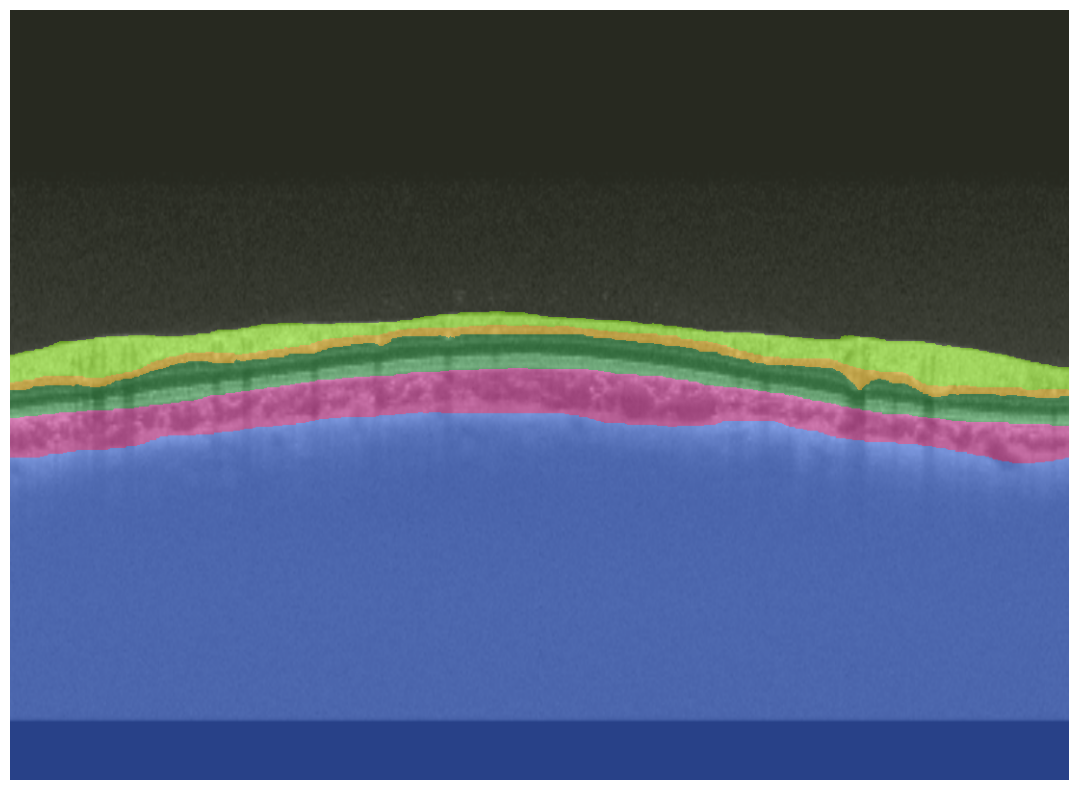

In [7]:
# transforms that will be applied to the input image, not used right now as we're using the feature_extractor, but could be useful later.
# transform = A.Compose(
#     [
#         A.Resize(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]),
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#     ]
# )

def preprocess_png_mask(mask):
    mask = mask.resize((TARGET_IMAGE_SIZE[1], TARGET_IMAGE_SIZE[0]), Image.Resampling.NEAREST)
    mask = mask.convert('L')
    mask_np = np.array(mask)
    mask = np.vectorize(mapping_dict.get)(mask_np).astype(np.int32)

    # add additional mask labels based from background class

    first_line_value = 0
    second_line_value = 1
    third_line_value = 2

    above_value = 3
    between_value = 4
    below_value = 5

    # Iterate over columns
    for j in range(mask.shape[1]):
        first_line_indices = np.where(mask[:, j] == first_line_value)[0]
        second_line_indices = np.where(mask[:, j] == second_line_value)[0]
        third_line_indices = np.where(mask[:, j] == third_line_value)[0]
        
        if first_line_indices.size > 0 and second_line_indices.size > 0 and third_line_indices.size > 0:
            topmost_first_line_index = first_line_indices[0]
            topmost_second_line_index = second_line_indices[0]
            bottommost_second_line_index = second_line_indices[-1]
            topmost_third_line_index = third_line_indices[0]
            bottommost_third_line_index = third_line_indices[-1]
            
            # Set values above the first line to above_value
            mask[:topmost_first_line_index, j] = above_value
            
            # Set values between the second and third line to between_value
            mask[bottommost_second_line_index + 1:topmost_third_line_index, j] = between_value
            
            # Set values below the third line to below_value
            mask[bottommost_third_line_index + 1:, j] = below_value
    
    return mask

def transforms(batch):
    transformed_masks = []
    for seg_mask in batch["annotation"]:
        seg_mask = preprocess_png_mask(seg_mask)
        transformed_masks.append(seg_mask)
    
    # transformed_batch = feature_extractor(batch['image'], transformed_masks)
    transformed_batch = feature_extractor(batch['image'])
    transformed_batch["labels"] = transformed_masks
    return transformed_batch


# apply the input transforms on all the datasets.
train_dataset.set_transform(transforms)
validation_dataset.set_transform(transforms)
test_dataset.set_transform(transforms)

# visualize a random image/label pair
index = 42

print(train_dataset[index]['pixel_values'].shape, train_dataset[0]['labels'].shape)

visualize_seg_mask(
    train_dataset[index]["pixel_values"],
    train_dataset[index]["labels"]
)

Lets try a little test forward pass of the untrained model to see if everything works

In [ ]:
# random test image
test_image_path = "/mnt/mass_storage/master_ai/GOALS/Train/Image/0004.png"

image = Image.open(test_image_path).resize((640,640))

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
logits.shape

torch.Size([1, 6, 200, 275])

now let's plot it

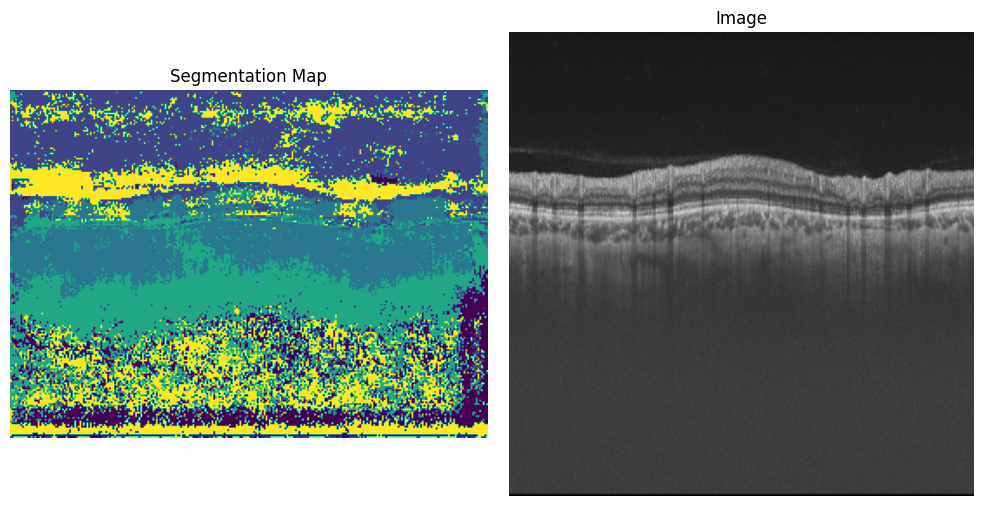

In [ ]:
segmap = logits.argmax(dim=1).squeeze()

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # You can adjust the figsize as needed

# Plot the segmentation map on the first subplot
ax1.imshow(segmap)
ax1.set_title('Segmentation Map')
ax1.axis('off')  # Hide the axis

# Plot the image on the second subplot
ax2.imshow(image)
ax2.set_title('Image')
ax2.axis('off')  # Hide the axis

# Show the figure
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Now lets do the actual training, we use the huggingface trainer and setup huggingface TrainingArguments

In [ ]:
epochs = 5 # enough epochs to get reasonably stable convergence with this learning rate
lr = 0.0006 # pretty randomly set, I made it one order of magnitude higher than the default
batch_size = 4 # change when gpu is bigger

# not used yet
hub_model_id = "segformer-b0-finetuned-segments-fundus-oct"

# change this to your local output folder
output_folder = "/home/parting/repositories/Fundus-OCT-challenge/output"

# due tue RAM issues lets limit the validation to only the first 25
max_val_n = 25


In [ ]:

training_args = TrainingArguments(
    output_folder,
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    remove_unused_columns=False,
    save_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

In [ ]:

metric = evaluate.load("mean_iou")
num_labels = len(id2label)

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred

        logits_tensor = torch.from_numpy(logits)

        # batched version to help with RAM problems, pretty slow so I'm not using it right now
        # the nn.functional.interpolate will run out of system RAM because the input images are so huge
        # logits_tensor_placeholder = torch.zeros((logits.shape[0], *labels.shape[-2:]))
        # for i in range(logits.shape[0]):

        #     target_size = (labels.shape[-2], labels.shape[-1])
        #     logits_tensor_placeholder[i] = nn.functional.interpolate(
        #         logits_tensor[i][None, :],
        #         size=target_size,
        #         mode="bilinear",
        #         align_corners=False
        #     ).argmax(dim=1)
        # logits_tensor = logits_tensor_placeholder



        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)


        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
                
        return metrics

In [ ]:
from transformers import Trainer

index_filter = lambda sample, i: True if i < max_val_n else False
validation_dataset = validation_dataset.filter(index_filter, with_indices=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

Filter:   0%|          | 0/25 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

  0%|          | 0/125 [00:00<?, ?it/s]

{'loss': 0.1296, 'learning_rate': 0.0005951999999999999, 'epoch': 0.04}
{'loss': 0.2106, 'learning_rate': 0.0005903999999999999, 'epoch': 0.08}
{'loss': 0.1804, 'learning_rate': 0.0005855999999999999, 'epoch': 0.12}
{'loss': 0.1717, 'learning_rate': 0.0005807999999999999, 'epoch': 0.16}
{'loss': 0.1272, 'learning_rate': 0.0005759999999999999, 'epoch': 0.2}
{'loss': 0.2048, 'learning_rate': 0.0005711999999999999, 'epoch': 0.24}
{'loss': 0.1015, 'learning_rate': 0.0005663999999999999, 'epoch': 0.28}
{'loss': 0.1139, 'learning_rate': 0.0005616, 'epoch': 0.32}
{'loss': 0.1313, 'learning_rate': 0.0005568, 'epoch': 0.36}
{'loss': 0.0873, 'learning_rate': 0.000552, 'epoch': 0.4}
{'loss': 0.0946, 'learning_rate': 0.0005472, 'epoch': 0.44}
{'loss': 0.0668, 'learning_rate': 0.0005424, 'epoch': 0.48}
{'loss': 0.1339, 'learning_rate': 0.0005376, 'epoch': 0.52}
{'loss': 0.0725, 'learning_rate': 0.0005327999999999999, 'epoch': 0.56}
{'loss': 0.0716, 'learning_rate': 0.0005279999999999999, 'epoch': 0

  0%|          | 0/7 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8736448508013377, 0.6906734520620751, 0.8499256438655968, 0.995144576652684]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9268932768583944, 0.8597368914076954, 0.911296349471066, 0.9977204150413199]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.040049996227025986, 'eval_mean_iou': 0.8523471308454234, 'eval_mean_accuracy': 0.923911733194619, 'eval_overall_accuracy': 0.9786698619134633, 'eval_per_category_iou': [0.8736448508013377, 0.6906734520620751, 0.8499256438655968, 0.995144576652684], 'eval_per_category_accuracy': [0.9268932768583944, 0.8597368914076954, 0.911296349471066, 0.9977204150413199], 'eval_runtime': 64.1269, 'eval_samples_per_second': 0.39, 'eval_steps_per_second': 0.109, 'epoch': 4.0}
{'loss': 0.0271, 'learning_rate': 0.0001152, 'epoch': 4.04}
{'loss': 0.0287, 'learning_rate': 0.00011039999999999999, 'epoch': 4.08}
{'loss': 0.0307, 'learning_rate': 0.00010559999999999998, 'epoch': 4.12}
{'loss': 0.0388, 'learning_rate': 0.0001008, 'epoch': 4.16}
{'loss': 0.0298, 'learning_rate': 9.599999999999999e-05, 'epoch': 4.2}
{'loss': 0.0291, 'learning_rate': 9.12e-05, 'epoch': 4.24}
{'loss': 0.0282, 'learning_rate': 8.639999999999999e-05, 'epoch': 4.28}
{'loss': 0.0313, 'learning_rate': 8.16e-05, 'epoch':

TrainOutput(global_step=125, training_loss=0.052594325363636014, metrics={'train_runtime': 310.0, 'train_samples_per_second': 1.613, 'train_steps_per_second': 0.403, 'train_loss': 0.052594325363636014, 'epoch': 5.0})

torch.Size([1, 6, 200, 275])


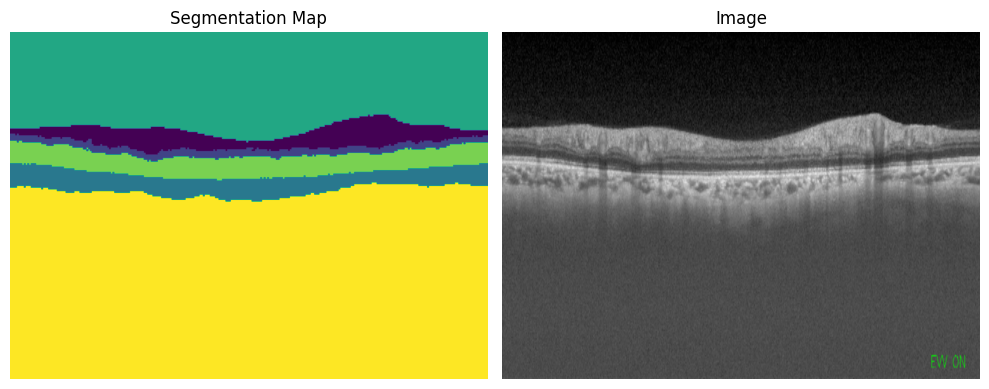

In [ ]:
# take a random test image and show the result. should probably take this from the actual test dataset we constructed earlier

test_image_path = "/mnt/mass_storage/master_ai/GOALS/Test/Image/0201.png"
image = Image.open(test_image_path).resize((TARGET_IMAGE_SIZE[1], TARGET_IMAGE_SIZE[0]))

inputs = feature_extractor(images=image, return_tensors="pt").to("cuda:0")

logits = trainer.model(**inputs).logits
print(logits.shape)
segmap = logits.argmax(dim=1).squeeze().cpu().numpy()

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # You can adjust the figsize as needed

# Plot the segmentation map on the first subplot
ax1.imshow(segmap)
ax1.set_title('Segmentation Map')
ax1.axis('off')  # Hide the axis

# Plot the image on the second subplot
ax2.imshow(image)
ax2.set_title('Image')
ax2.axis('off')  # Hide the axis

# Show the figure
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

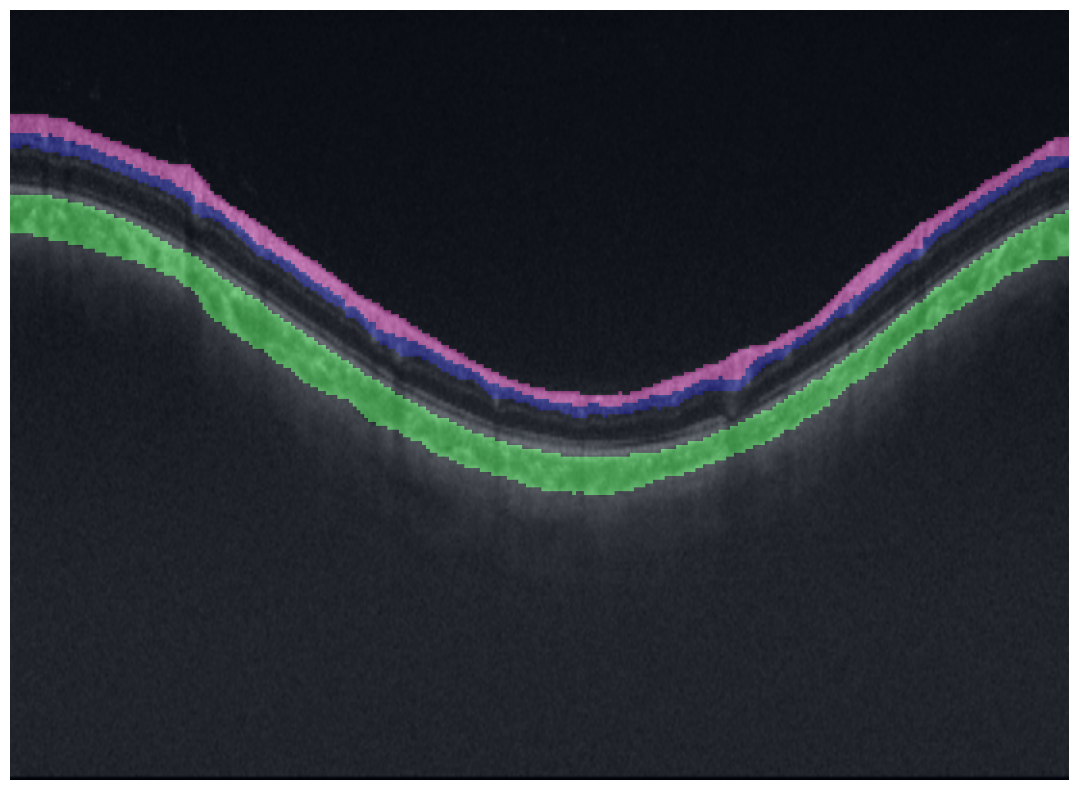

In [ ]:
img_for_plotting = inputs["pixel_values"].cpu().squeeze().numpy()

target_shape = img_for_plotting.shape[-2:]
resized_segmap = resize(segmap, target_shape, order=0, mode='constant', anti_aliasing=False, preserve_range=True)


visualize_seg_mask(
    img_for_plotting,
    resized_segmap
)